# Analysez les ventes de votre entreprise

In [3]:
#Importation des librairies
import pandas as pd
import numpy as np
import numpy, math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
%matplotlib inline
import scipy.stats as st
from scipy.stats import gaussian_kde
from scipy.stats import bartlett
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from datetime import date

In [4]:
# Lecture de la table
df_1=pd.read_csv('ventesLibrairie.csv',parse_dates=[7], sep=',', header=0)
df_1.head()

,client_id,sex,birth,session_id,categ,id_prod,price,date,mois
0,c_329,f,1967,s_1,0,0_1259,11.99,2021-03-01 00:01:07.843138,3
1,c_664,m,1960,s_2,0,0_1390,19.37,2021-03-01 00:02:26.047414,3
2,c_580,m,1988,s_3,0,0_1352,4.50,2021-03-01 00:02:38.311413,3
3,c_7912,f,1989,s_4,0,0_1458,6.55,2021-03-01 00:04:54.559692,3
4,c_2033,f,1956,s_5,0,0_1358,16.49,2021-03-01 00:05:18.801198,3


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   336816 non-null  object        
 1   sex         336816 non-null  object        
 2   birth       336816 non-null  int64         
 3   session_id  336816 non-null  object        
 4   categ       336816 non-null  int64         
 5   id_prod     336816 non-null  object        
 6   price       336816 non-null  float64       
 7   date        336816 non-null  datetime64[ns]
 8   mois        336816 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 23.1+ MB


In [6]:
# transformation du dtype de categ en categorie
df_1['categ'] = df_1['categ'].astype("category")
d = date(2022, 3, 1)

# Mission 2 : les différentes analyses effectuées

### Concernant les clients

In [7]:
# La fonction de répartition empirique de la variables qualitative client_id
effectifs = df_1["client_id"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab_client = pd.DataFrame(modalites, columns = ["client_id"]) # création du tableau à partir des modalités
tab_client["n"] = effectifs.values
tab_client["f"] = tab_client["n"] / len(df_1)
tab_client= tab_client.sort_values("n",ascending=False) # tri des valeurs de la variable X (croissant)
tab_client

,client_id,n,f
0,c_1609,12855,0.038166
1,c_6714,4473,0.013280
2,c_3454,3275,0.009723
3,c_4958,2562,0.007607
4,c_2140,195,0.000579
...,...,...,...
8576,c_8140,1,0.000003
8577,c_6200,1,0.000003
8578,c_1675,1,0.000003
8579,c_8506,1,0.000003


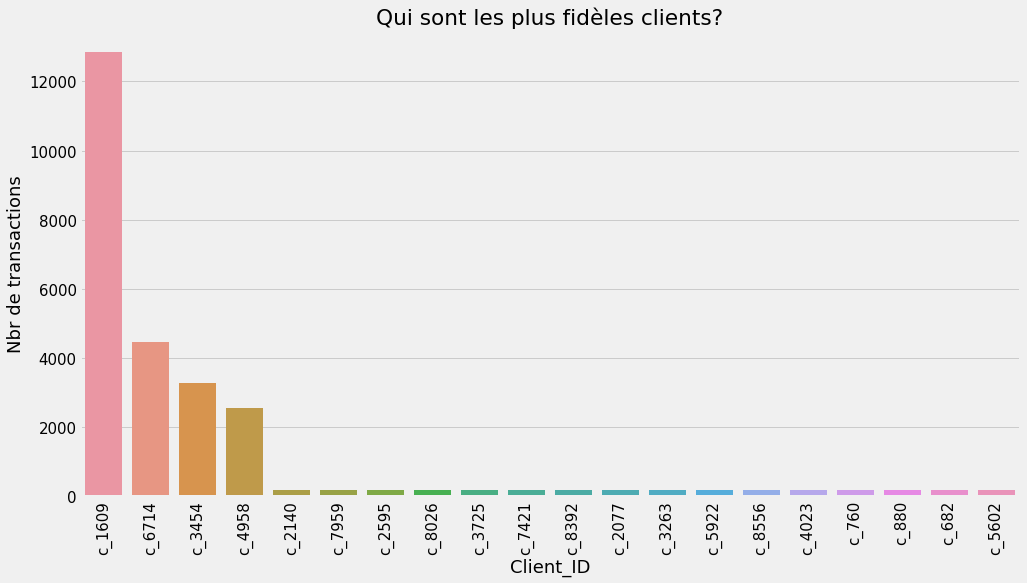

In [8]:
# visualiser les plus fidèle client
plt.style.use("fivethirtyeight")
customer_counts = df_1.client_id.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,8))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Nbr de transactions")
plt.xlabel("Client_ID")
plt.title("Qui sont les plus fidèles clients?");
plt.xticks(rotation=90);
plt.savefig('Qui sont les plus fidèles clients ?.png', dpi=300, transparent=False) 

<div class ="alert alert-block alert-success"> 
L'entreprise compte <b>8600 clients</b> et les plus fidèles clients sont <b>c_1609, c_6714, c_3454...</b>
</div>

In [9]:
# Préparation pour le calcul de l'âge des clients
df_1['birth'] = df_1['birth'].astype(str)
# Transformation de naissance en age
def calculate_age(birth):
    birth = datetime.strptime(birth, "%Y").date()
    today = date(2022, 3, 1)
    return today.year - birth.year
# Création d'une variable âge
df_1['age'] = df_1['birth'].apply(calculate_age)
# ordonner et projeter les variables dont on aura besoin
df_1=df_1[['client_id','sex','age','session_id','categ','id_prod','price','date']]
df_1.head()

,client_id,sex,age,session_id,categ,id_prod,price,date
0,c_329,f,55,s_1,0,0_1259,11.99,2021-03-01 00:01:07.843138
1,c_664,m,62,s_2,0,0_1390,19.37,2021-03-01 00:02:26.047414
2,c_580,m,34,s_3,0,0_1352,4.50,2021-03-01 00:02:38.311413
3,c_7912,f,33,s_4,0,0_1458,6.55,2021-03-01 00:04:54.559692
4,c_2033,f,66,s_5,0,0_1358,16.49,2021-03-01 00:05:18.801198


In [10]:
# La fonction de répartition empirique de la variable qualitative sex
effectifs = df_1["sex"].value_counts()
modalites = effectifs.index # L'index de effectifs contient les modalités

tab_sex = pd.DataFrame(modalites, columns = ["sex"]) # Création du tableau à partir des modalités
tab_sex ["n"] = effectifs.values
tab_sex ["f"] = tab_sex ["n"] / len(df_1)
tab_sex = tab_sex .sort_values("n",ascending=False) # Tri des valeurs de la variable X (croissant)
tab_sex 

,sex,n,f
0,m,169241,0.502473
1,f,167575,0.497527


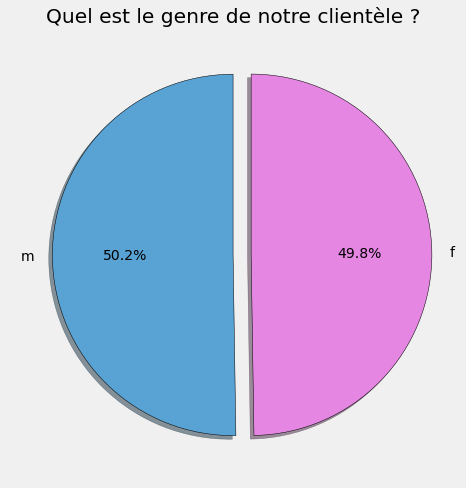

In [11]:
# Visualisation des proportions par genre
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (7,7))
plt.style.use("fivethirtyeight")

slices = [169241,167575]
labels = ['m','f']
explode = [0, 0.1]
cl=['#58A2D4','#E686E3']

plt.pie(slices, labels=['m','f'], explode=explode, shadow=True, startangle=90, autopct='%1.1f%%',colors=cl, wedgeprops={'edgecolor': 'black'})

plt.title("Quel est le genre de notre clientèle ?")
plt.tight_layout()
plt.show()

In [12]:
# Répartition du genre en fonction de la catégorie de produits
df_1.groupby(["categ"]).sex.value_counts()

categ  sex
0      m      105683
       f      103846
1      f       55469
       m       54266
2      m        9292
       f        8260
Name: sex, dtype: int64

<div class ="alert alert-block alert-info"> 

On va employé une moyenne (arithmétique linéaire et non pondérée avec coef ): 
    
$ \ $   
      
$ \displaystyle\ \bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i $ 
    
$ \ $   
    
Pour calculer :
    
-L'âge moyen de l'ensemble de la clientèle.
    
-En fonction du genre l'âge moyen et l'achat moyen . 
    
-En fonction de la catégorie de produit l'âge moyen et la moyenne des ventes . 
    
 


</div> 

In [13]:
# création dataframe 
ClientAge=pd.pivot_table(df_1, values="age", index=["client_id","sex"], columns=[])
ClientAge=ClientAge.reset_index()
#Discrétisation de la variable age
ClientAge.age=pd.cut(ClientAge.age,bins=10)
ClientAge=ClientAge.groupby(['age','sex']).client_id.count().reset_index()

Text(0.5, 1.0, 'Répartition des genres par âges ')

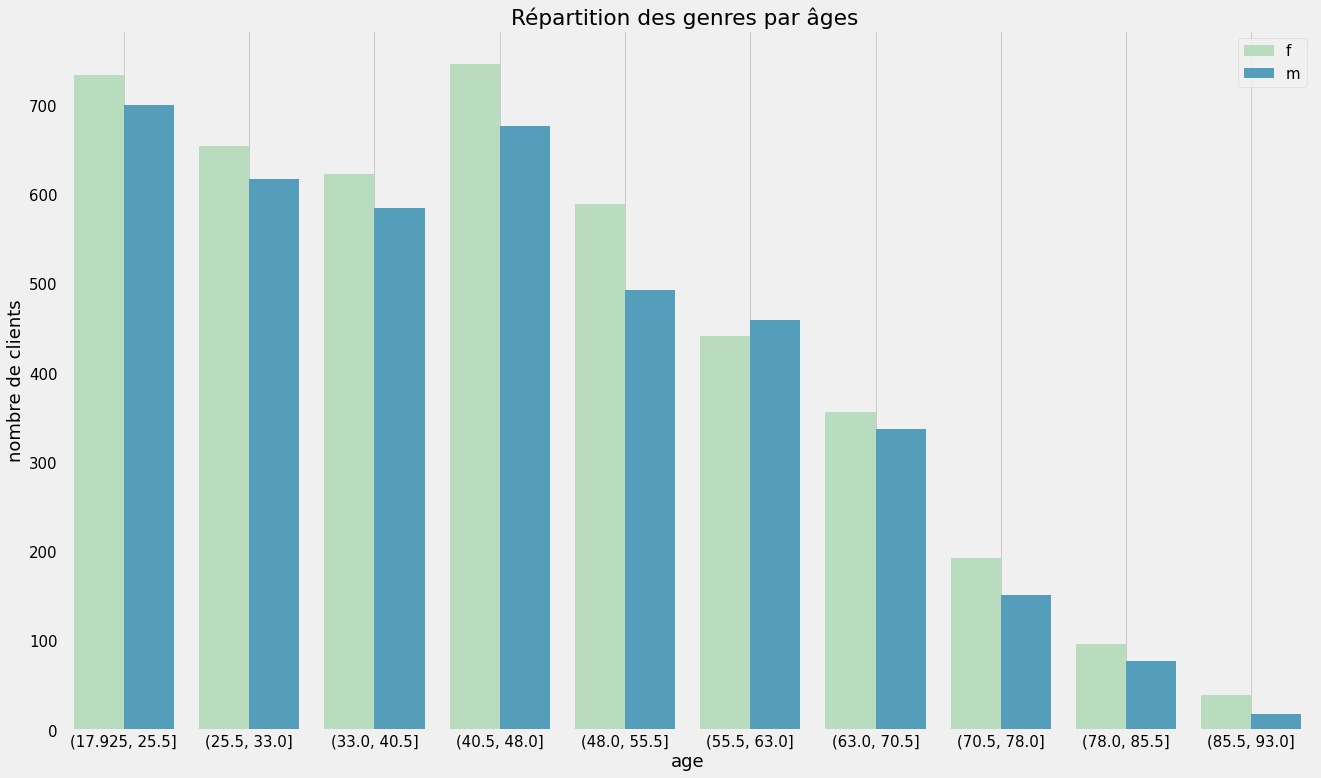

In [14]:
# Visualisation de la répartition des genres par âges

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,12))
sns.barplot(x="age", y="client_id", hue="sex", data=ClientAge,palette="GnBu", ci=None,);
plt.ylabel("nombre de clients")
plt.grid()
plt.legend()
plt.title("Répartition des genres par âges ")

In [15]:
# Moyenne d'âge de l'ensemble des clients
df_1['age'].mean()

44.176603843047836

In [16]:
# Moyenne d'âge et achat moyen en fonction du genre
df_1.groupby(['sex']).mean().round(2)

,age,price
sex,,
f,44.74,17.07
m,43.62,17.36


In [17]:
# Moyenne d'âge et moyenne de vente en fonction de la catégorie de produit
df_1.groupby(['categ']).mean().round(2)

,age,price
categ,,
0,43.90,10.65
1,47.66,20.48
2,25.73,75.17


<div class ="alert alert-block alert-success">
    
La clientèle de notre entreprise est mixte, nous avons <b>5O,2% de m et 49,8% de f</b> et sa répartition par age nous indique une clientèle plus jeune qu'agées. Quant à sa répartition en fonction de la catégorie de produits, l'équilibre par genre est conservé.
    
$ \ $   
     
L'âge moyen de l'ensemble de la clientèle est de <b>44,17 ans</b> .
    
$ \ $   
           
En fonction du genre<b>, les moyennes d'âge</b> varient peu  <b>44,74 ans pour les femmes et 43,62 pour les hommes</b>.
Quant aux <b>moyennes de leurs achats</b> elles sont pratiquement identiques <b>17,07 pour les femmes et 17,36 pour le hommes</b>.
 
$ \ $   
 
Cependant,en fonction de la catégorie de produits achetée <b>les moyennes d'âge</b> sont très marquées,on a pour  <b>categ0=43,90 ans, pour categ1 = 47,66 ans et pour categ2 = 25,73 ans</b>.Concernant <b>les moyennes de prix par catégorie de produits</b>, elles sont egalement très marquées avec <b>categ0 = 10,65 € , categ1 = 20,48 € et categ2 = 75,17 €</b>.On remarque aussi que <b>les clients de la categ 2</b>  sont en moyenne beaucoup <b>plus jeunes avec 25,73 ans</b> que les clients des catégories de produits 0 et 1 qui ont en moyenne respectivement 43,90 et 47,66 ans.

$ \ $
    
En somme, on a une clientèle mixte avec une répartition equilibrée par catégorie de produits et on a une segmentation des âges par catégorie de produits allant de la categ 2 pour les plus jeunes avec avec une moyenne d'achat plus importante, à plus agées pour la categ 0 avec une moyenne d'achat la plus basse.

</div>

### Concernant les catégories et les produits

In [18]:
# La fonction de répartition empirique de la variable qualitative id_prod 
effectifs = df_1["id_prod"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab_prod = pd.DataFrame(modalites, columns = ["id_prod"]) # création du tableau à partir des modalités
tab_prod["n"] = effectifs.values
tab_prod["f"] = tab_prod["n"] / len(df_1)
tab_prod = tab_prod.sort_values("n",ascending=False) # tri des valeurs de la variable X (croissant)

tab_prod

,id_prod,n,f
0,1_369,1081,0.003209
1,1_417,1062,0.003153
2,1_498,1036,0.003076
3,1_414,1027,0.003049
4,1_425,1013,0.003008
...,...,...,...
3235,0_1284,1,0.000003
3236,0_886,1,0.000003
3237,2_28,1,0.000003
3238,0_549,1,0.000003


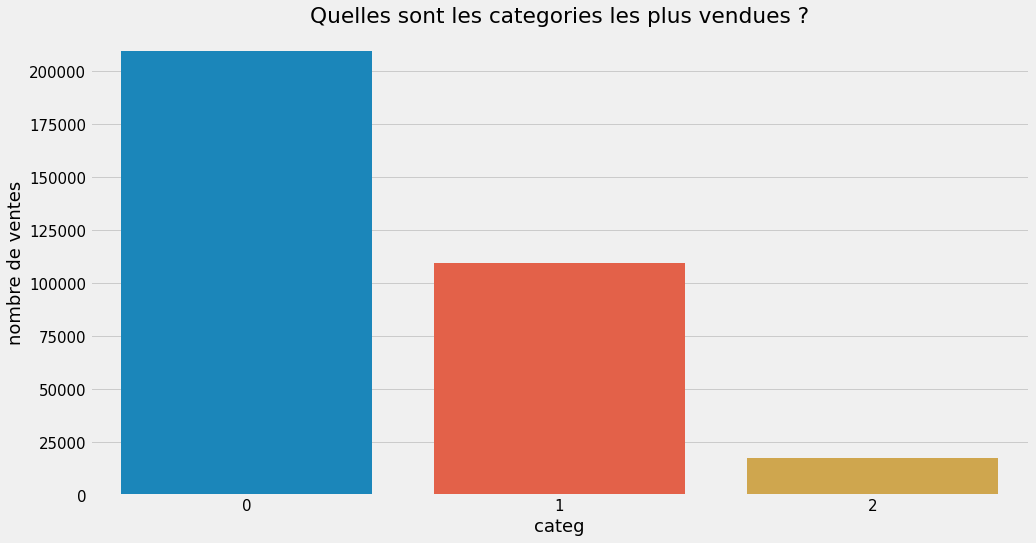

In [19]:
# visualisation des catégories de produits les plus vendus 
categ_counts = df_1.categ.value_counts().sort_values(ascending=False).iloc[:] 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,8))
sns.barplot(categ_counts.index, categ_counts.values, order=categ_counts.index)
plt.ylabel("nombre de ventes")
plt.xlabel("categ")
plt.title("Quelles sont les categories les plus vendues ?");

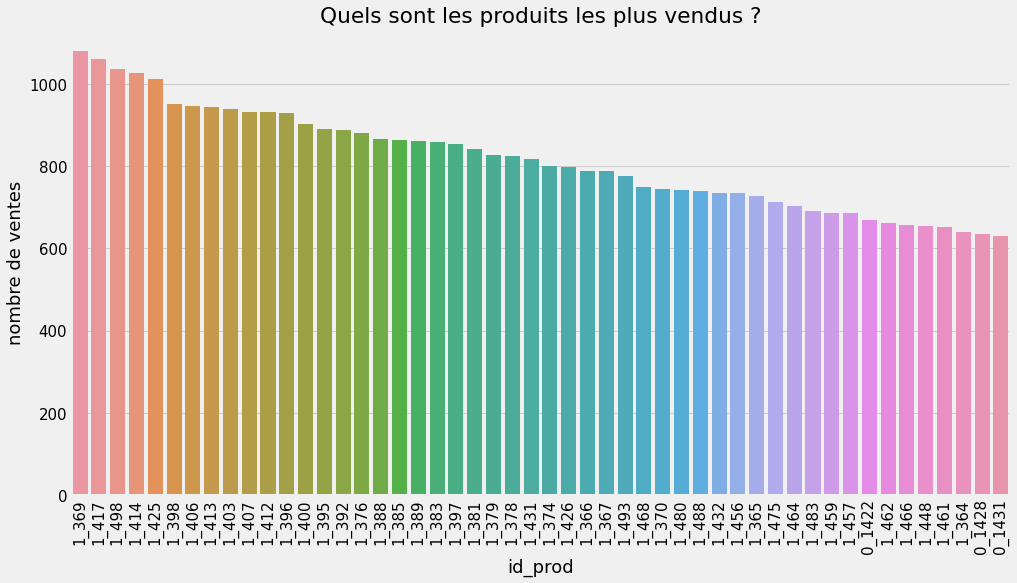

In [20]:
# visualisation des produits les plus vendus
bestprod_counts = df_1.id_prod.value_counts().sort_values(ascending=False).iloc[0:50] 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,8))
sns.barplot(bestprod_counts.index, bestprod_counts.values, order=bestprod_counts.index)
plt.ylabel("nombre de ventes")
plt.xlabel("id_prod")
plt.title("Quels sont les produits les plus vendus ?");
plt.xticks(rotation=90);

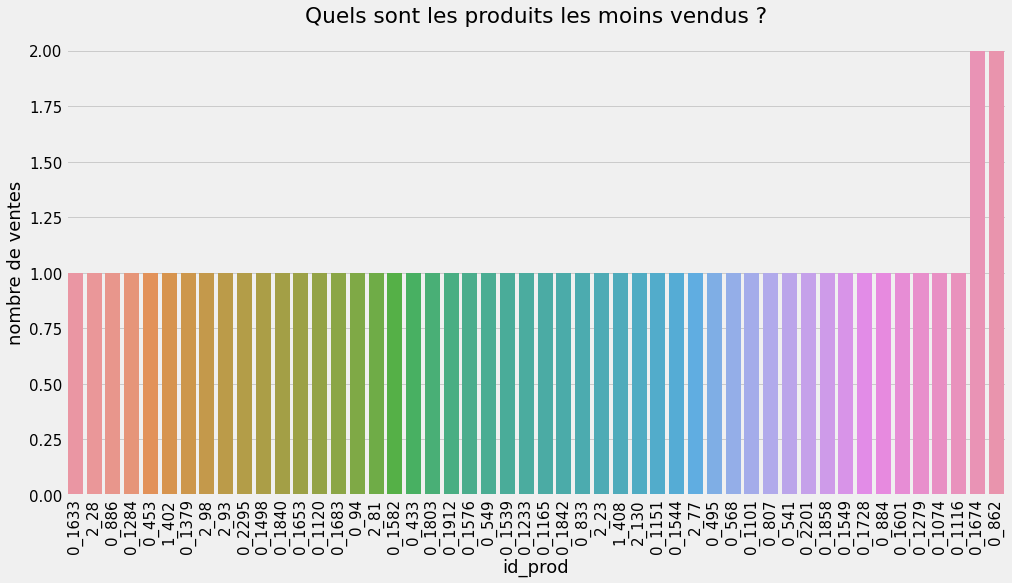

In [21]:
# visualisation des produits les moins vendus
feeblestprod_counts = df_1.id_prod.value_counts().sort_values(ascending=True).iloc[0:50] 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,8))
sns.barplot(feeblestprod_counts.index, feeblestprod_counts.values, order=feeblestprod_counts.index)
plt.ylabel("nombre de ventes")
plt.xlabel("id_prod")
plt.title("Quels sont les produits les moins vendus ?");
plt.xticks(rotation=90);

<div class ="alert alert-block alert-success"> 

Le site de e-commerce propose <b>3 265 produits</b> divisés en <b>3 catégories</b> de produits  avec une <b> catégorie 0 :</b> qui enregistre plus de <b>200 000 ventes</b>  soit deux fois plus vendues que <b>la categorie 1 qui compte plus de 100 000 ventes</b>  et 8 fois plus que <b>la categorie 2 avec moins de 25 000 ventes</b> .
    
Les produits les plus vendus sont <b>1-369, 1-417 et 1-498</b>. Quant aus moins vendus, ceux sont <b>0_1633, 2_28 et 0_886</b>.
</div>

### Concernant les prix

In [22]:
#Resultat de l'ensemble des ventes 
Result_ventes=df_1.price.sum().round()
Result_ventes

5798351.0

In [23]:
#Resultat des ventes par catégorie de produits
ventes_categ=df_1.groupby(['categ']).price.sum().round()
ventes_categ

categ
0    2231496.0
1    2247384.0
2    1319471.0
Name: price, dtype: float64

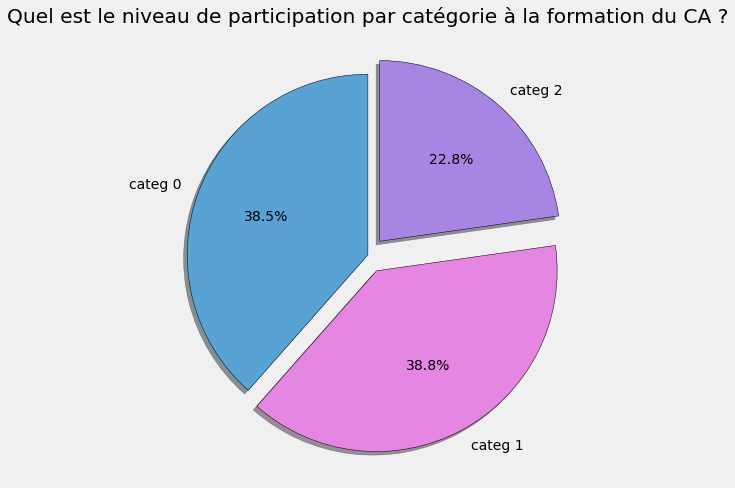

In [24]:
# visualisation du niveau de participation par catégorie à la formation du CA
plt.rcParams.update({'font.size': 11})
plt.figure(figsize = (10,7))
plt.style.use("fivethirtyeight")

slices = [2231496.0,2247384.0,1319471.0]
labels = ['categ 0','categ 1','categ 2']
explode = [0, 0.1, 0.1]
cl=['#58A2D4','#E686E3','#A786E3']

plt.pie(slices, labels=['categ 0','categ 1','categ 2'], explode=explode, shadow=True, startangle=90, autopct='%1.1f%%',colors=cl, wedgeprops={'edgecolor': 'black'})

plt.title("Quel est le niveau de participation par catégorie à la formation du CA ?")
plt.tight_layout()
plt.show()

<div class ="alert alert-block alert-info"> 

<b>Mesure de concentration des ventes sur la variable price avec une courbe de Lorenz et un indice de Gini</b>

On va visualiser si les ventes sont répartient de manière égalitaires ou non et établir une mesure numerique de concentration avec l'indice de Gini $gini=2×S$.
    
$S$=surface de concentration


<div class ="alert alert-block alert-info"> 

<b>Les mesures de distribution et de dispersion des ventes</b>

$ \ $   
            
Afin d'avoir une idée de la variabilité autour de la tendance centrale des prix par catégories de produits , on va effectuer les mesures de distribution et de dispersion suivantes : 

$ \ $   
        
    
<b>Le mode</b> de prix par catégorie de produit s'exprime par la fonction de répartition empirique de la manière suivante :

$ F_{emp^(x)}=\frac{1}{n}\sum_{i=1}^{n}I\{x_i\leq{x}\} $ 

$ \ $   
    
où I est la fonction indicatrices, et où

$ I_{\{x_i\leq{x}\}}=\begin{cases} 1 & si & x_i\leq{x}\\ 0 &  sinon \end{cases} $ 

$ \ $

<b>La moyenne</b> (arithmétique linéaire et non pondérée avec coef ) de prix par categorie de produit: 
    
$ \displaystyle\ \bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i $

$ \ $
    
<b>La mediane</b> de prix par catégorie de produit :

$ Med=x_{(\frac{n+1}{2})} $ et  si $n$ est pair la mediane vaut : $ Med=\frac{1}{2}(x_{(\frac{n}{2})}+ x_{(\frac{n}{2}+1)}) $
    
$ \ $ 
    
<b>La variance</b> empirique de prix par catégorie de produit:

$ \displaystyle\ v=\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^2 $

$ \ $

<b>L’écart-Type</b> empirique de prix par catégorie de produit, c’est la racine carrée de la variance empirique:
    
$ s=\sqrt{v} $ 

$ \ $

<b>Le skewness</b> empirique de prix par catégorie de produit:


$ \gamma_1=\frac{\mu_3}{S^3}$   avec   $\mu_3=\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^3 $

$ \ $
    
<b>Le kurtosis</b> empirique de prix par catégorie de produit:


$ \gamma_2=\frac{\mu_4}{S^4}$   avec   $\mu_4=\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^4 $
    

$ \ $

$ \ $

<b>Statistiques inferentielles:</b>

$ \ $
    
On va calculer <b>la statistique du test de Levene</b> pour l'égalité des variances : 
    
    
    
$\displaystyle\ W = \frac{(N-k)} {(k-1)}
               \frac{\sum_{i=1}^{k}N_{i}(\bar{Z}_{i.}-\bar{Z}_{..})^{2} }
               {\sum_{i=1}^{k}\sum_{j=1}^{N_i}(Z_{ij}-\bar{Z}_{i.})^{2} } $
    
$ \ $
  
On utilisera un parametre $ Z_{ij} = |Y_{ij} - \bar{Y}_{i.}'|$ où $\bar{Y}_{i.}'$ est une Moyenne ajustée similaire à la moyenne intermédiaire, sauf qu'ici on utilise des valeurs de percentile différentes . On fait le choix de rogner 5 % des points dans les queues inférieure et supérieure, c'est-à-dire à calculer la moyenne pour les données situées entre les 5e et 95e percentiles.   
    
$ \ $
    
On emettra pour hypothèses:   
 
$ \ $
   
H0:  les variances sont égales $\sigma_{1}^{2} = \sigma_{2}^{2} = \ldots = \sigma_{k}^{2}$

H1:  les variances ne sont pas égales $\sigma_{i}^{2} \ne \sigma_{j}^{2}$

avec un seuil $α = 0.05$   

$ \ $

$Y$ variable 
    
$k$ sous-groupes 
    
$N$ échantillon de taille 
    
$N_i$ la taille de l'échantillon du $i$ème sous-groupe
    

$ \ $


$ \ $
    
On va utilise  <b>t-test de Welch</b> qui est une adaptation de <b>la statistique du test de Student's  </b>, eu egard aux diffèrences de variances découvertes afin d'estimer l'égalité des moyennes:

$ \ $
    
$ {\displaystyle t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{\bar {\Delta }}}}}$

$ \ $

où ${\displaystyle s_{\bar {\Delta }}={\sqrt {{\frac {s_{}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}}}.}$
    

$ \ $
        
On emettra pour hypothèses:   
 
$ \ $
   
H0:  les moyennes sont égales $\bar {X_1}=\bar {X_2}$

H1:  les moyennes ne sont pas égales $\bar {X_1} \ne \bar {X_2}$

</div>

--------------------
0
moy:
 10.650057101487098
med:
 9.99
mod:
 0    4.99
dtype: float64
var:
 24.31432755818898
ect:
 4.930956049103356
skw:
 0.42526249508404307
kur:
 -0.3765649606700521


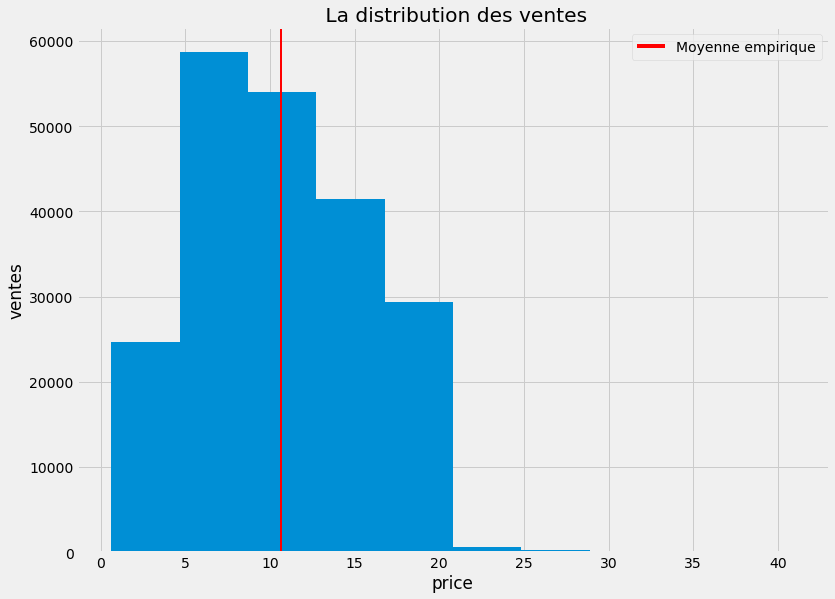

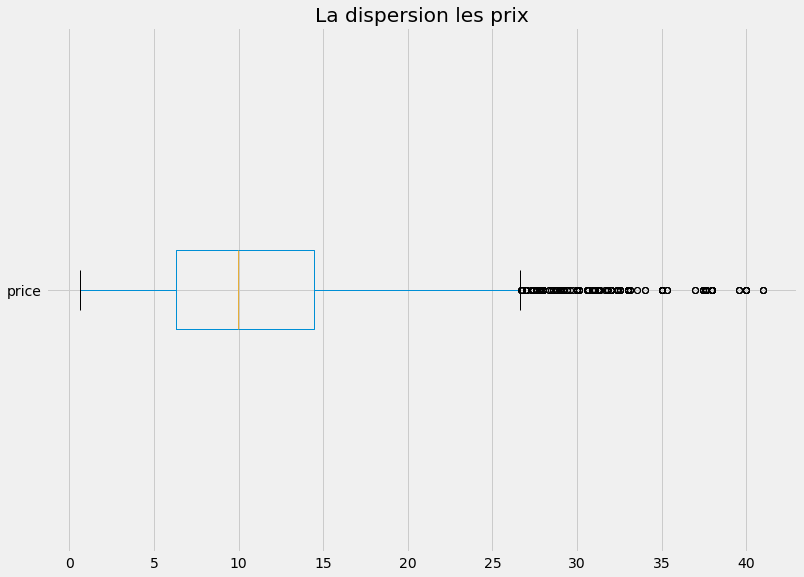

--------------------
1
moy:
 20.480105800342987
med:
 19.08
mod:
 0    15.99
dtype: float64
var:
 57.28857407270174
ect:
 7.568921592453032
skw:
 1.727288185296096
kur:
 8.154192525286465


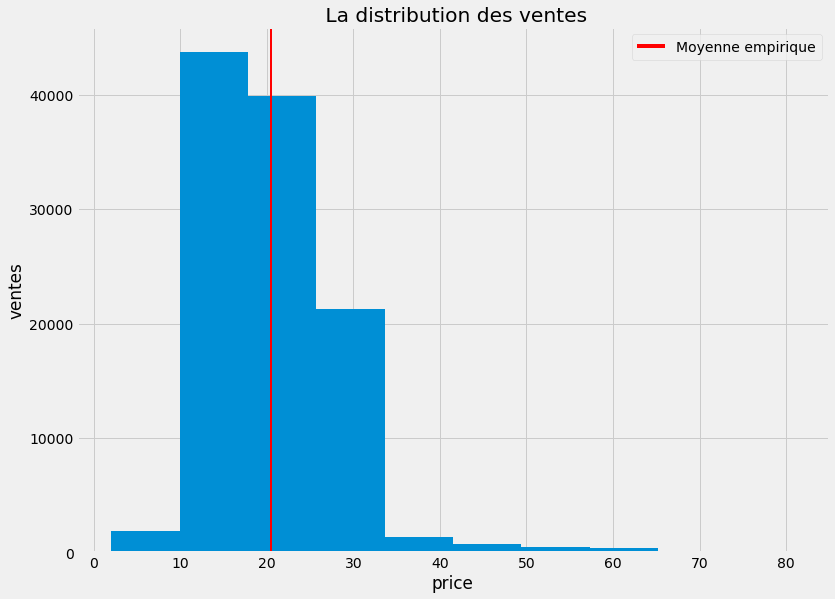

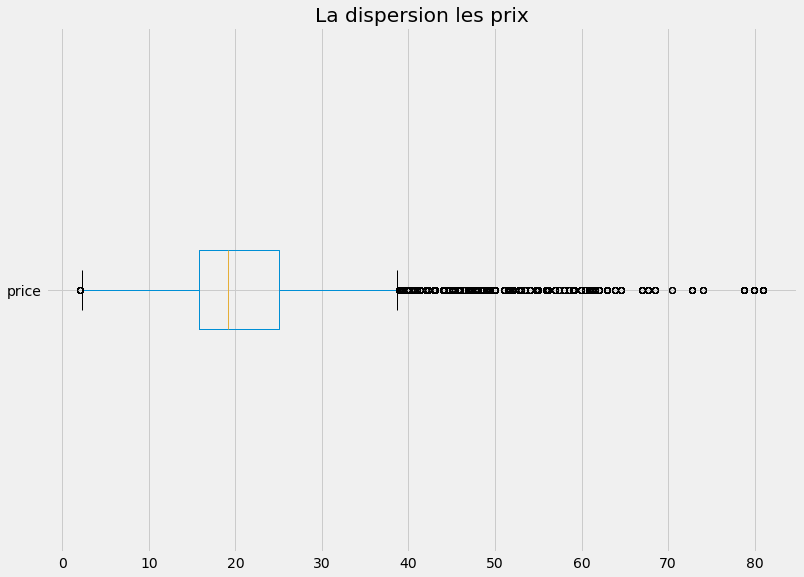

--------------------
2
moy:
 75.17494929352512
med:
 62.83
mod:
 0    68.99
dtype: float64
var:
 1527.1592950064933
ect:
 39.07888553946355
skw:
 2.3156310026622955
kur:
 5.537461225837998


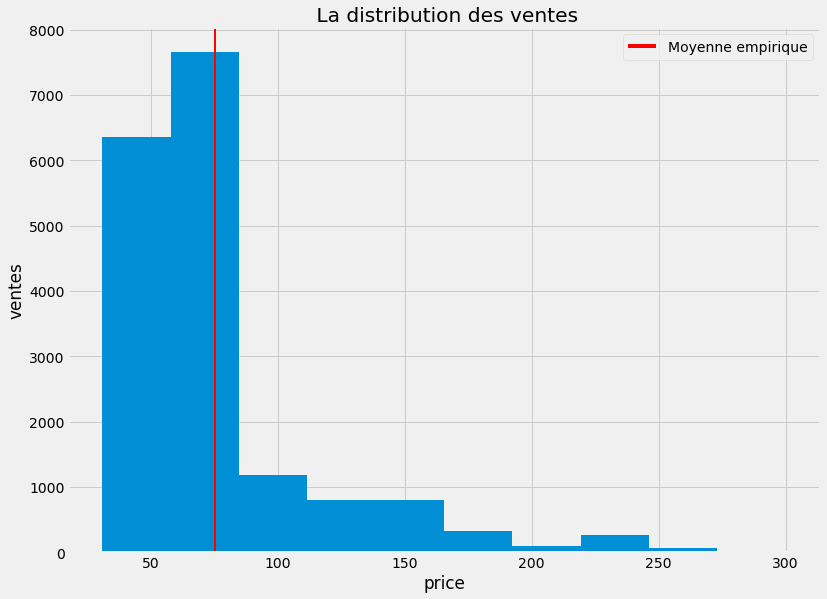

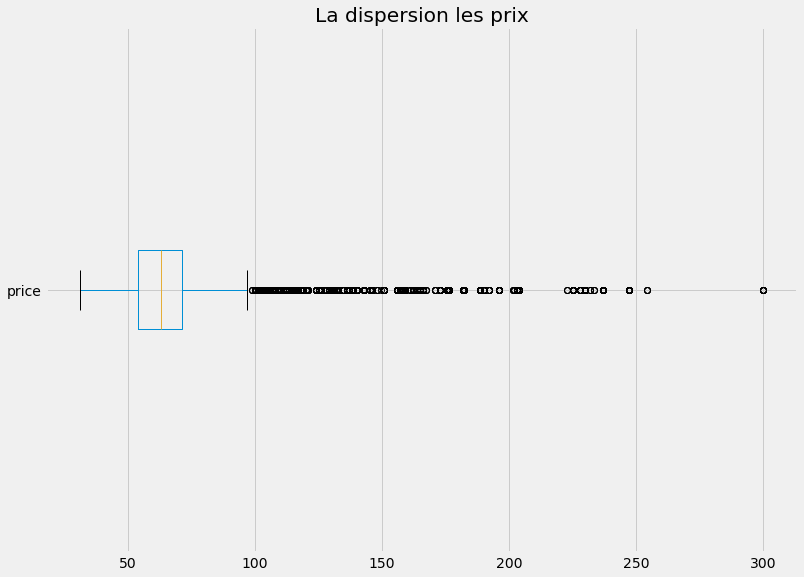

In [25]:
# visualisation de la distribution et dispertion des prix par categorie de produit:
for cat in df_1["categ"].unique():
    subset = df_1[df_1.categ == cat]# création sous echantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['price'].mean())# moyenne
    xbar=numpy.mean(subset['price'])
    print("med:\n",subset['price'].median())#mediane
    print("mod:\n",subset['price'].mode())#mode
    print("var:\n",subset['price'].var(ddof=0))# variance empirique
    print("ect:\n",subset['price'].std(ddof=0))# ecart-type empirique
    print("skw:\n",subset['price'].skew())#skewness
    print("kur:\n",subset['price'].kurtosis())#kurtosis
    
    plt.figure(figsize=(12,9))
    subset["price"].hist()# visualisation de la distribution des ventes par catégorie de produit
    plt.axvline(xbar, color='r', linewidth=2)
    import matplotlib.lines as mlines
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])#visualisation de la moyenne
    plt.title(" La distribution des ventes")
    plt.xlabel('price')
    plt.ylabel('ventes')
    plt.show()
        
    
    plt.figure(figsize=(12,9))
    subset.boxplot(column="price", vert=False)#visualisation de la dispersion des prix par catégories de produits
    plt.title("La dispersion les prix")
    plt.show()
    


In [26]:
# préparation des échantillons
cat0 = df_1[df_1["categ"]== 0]["price"]
cat1 = df_1[df_1["categ"]== 1]["price"]
cat2 = df_1[df_1["categ"]== 2]["price"]

In [27]:
# Utilisation du test de Levene pour l'égalité des variances
#'median' : Recommandé pour les distributions asymétriques (non normales).
#'mean' : Recommandé pour les distributions symétriques,moderate-tailed distributions.
#'trimmed' : Recommandé pour heavy-tailed distributions.
from scipy.stats import levene
st.levene(cat0,cat1,cat2, center='trimmed', proportiontocut=0.05)

LeveneResult(statistic=61333.573736683386, pvalue=0.0)

In [28]:
# Vérification des valeurs pour chaque variance
[np.var(x, ddof=1) for x in [cat0, cat1, cat2]]

[24.31444360152237, 57.289096140375136, 1527.2463076721538]

In [29]:
# Test d'egalité des moyennes cat0, cat1
st.ttest_ind(cat0, cat1, equal_var=False)

Ttest_indResult(statistic=-389.14150253905717, pvalue=0.0)

In [30]:
# Test d'egalité des moyennes cat0, cat2,
st.ttest_ind(cat0, cat2, equal_var=False)

Ttest_indResult(statistic=-218.59823349989813, pvalue=0.0)

In [31]:
# Test d'egalité des moyennes cat1, cat0,
st.ttest_ind(cat1, cat0, equal_var=False)

Ttest_indResult(statistic=389.14150253905717, pvalue=0.0)

In [32]:
# Test d'egalité des moyennes cat1, cat2,
st.ttest_ind(cat1, cat2, equal_var=False)

Ttest_indResult(statistic=-184.8656309736571, pvalue=0.0)

In [33]:
# Test d'egalité des moyennes cat2, cat0
st.ttest_ind(cat2, cat0, equal_var=False)

Ttest_indResult(statistic=218.59823349989813, pvalue=0.0)

In [34]:
# Test d'égalité des moyennes cat2, cat1
st.ttest_ind(cat2, cat1, equal_var=False)

Ttest_indResult(statistic=184.8656309736571, pvalue=0.0)

<div class ="alert alert-block alert-success"> 
    
<b>Sur les distributions et les dispersions</b> :les 3 catégories ont une inclinaison positive, elles sont «biaisées à droite» avec un kurtosis leptokurtic pour les catégories 1 et 2. De plus, le mode est inférieur à la médiane et elle même inférieure à la moyenne $Mode < Med < \bar{x}$, ce qui confirme l'asymetrie. Toujours par catégorie de produit, on observe également une plus forte dispersion pour la catégorie 2 vient ensuite la catégorie 1 puis enfin la catégorie 0. Ces résultat sont dues aux outliers.  
   
$ \ $   
    
<b>Sur l'égalité des variances:</b> la  p-value est égale à 0.0, donc, <b>on rejette l'hypothèse H0</b> , ce résultat nous suggère que les catégories n'ont pas des variances égales. Ceci n'est pas surprenant, étant donné que la variance d'échantillon de la categorie 2 est beaucoup plus grande que celle de la catégorie 1 et 0.
  
$ \ $   
        
<b>Sur l'égalité des moyennes:</b> la p-value pour chaque echantillon est égale à 0.0, donc, <b>on rejette l'hypothèse H0</b>, ce resultat nous suggère que les catégories n'ont pas de moyennes égales. Ceci n'est pas surprenant, étant donné que les moyennes des échantillons de la categorie 2 est beaucoup plus grande que celle de la catégorie 1 et cette dernière plus grande que la moyenne de la catégorie 0.
  
$ \ $   
   
En somme, ces mesures  nous suggères que les ventes par catégories de produits sont hétérogènes. 
   
$ \ $   
     
En effet,les catégories de produits sont segmentés par niveaux de prix, néanmoins, le point commun à ces catégories est que la majorité des ventes pour ces 3 catégories sont en dessous de la moyenne. 
  
$ \ $   
      
Quant aux performances liées aux ventes,la catégorie 1 affiche des résultats quasi similaire à la catégorie 0 malgré un volume de vente deux fois inférieur à la catégorie 0 et la catégorie 2 enregistre un faible résultat de vente et de volume par rapport aux autres catégories.
 
</div>

### Fréquentation du site web

<div class ="alert alert-block alert-info"> 

<b>Mesure de la fréquentation du site internet</b>
    
Pour ce faire, nous allons transformer les dates en périodes afin d'avoir plus de visibilité sur la distribution des visites du site web.

</div>

In [35]:
# Determiner le debut et la fin de la periode
print("Date debute au {}".format(df_1.date.min()))
print("Date termine au {}".format(df_1.date.max()))

Date debute au 2021-03-01 00:01:07.843138
Date termine au 2022-02-28 23:59:58.040472


In [36]:
# Durée de recolte des variables
print(" Durée {}".format(df_1.date.max() - df_1.date.min()))

 Durée 364 days 23:58:50.197334


In [37]:
# Création dataframe pour la fréquentation du site web
by_day = pd.to_datetime(df_1['date']).dt.to_period('D').value_counts().sort_index()
by_day.index = pd.PeriodIndex(by_day.index)
df_month = by_day.rename_axis('month').reset_index(name='counts')
df_month

,month,counts
0,2021-03-01,961
1,2021-03-02,938
2,2021-03-03,905
3,2021-03-04,901
4,2021-03-05,939
...,...,...
360,2022-02-24,1076
361,2022-02-25,990
362,2022-02-26,1101
363,2022-02-27,1108


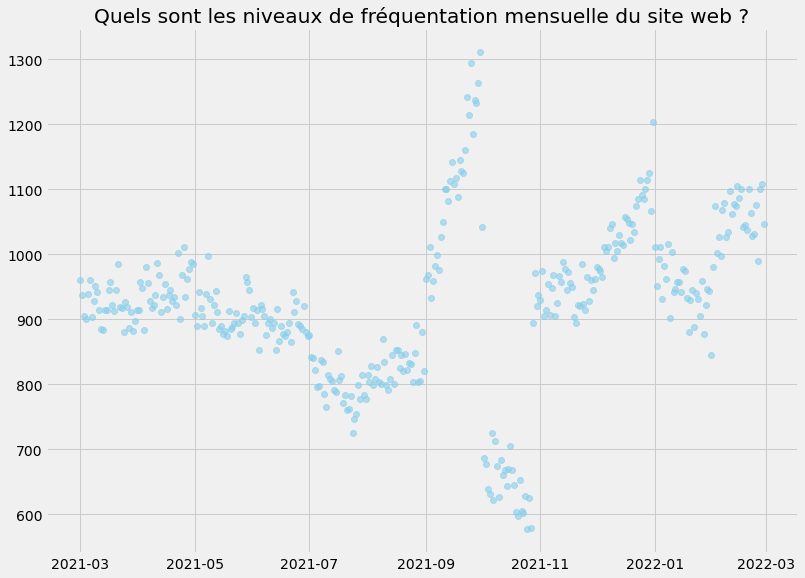

In [38]:
# Visualisation de la fréquentation du site web par mois
plt.figure(figsize=(12,9))
plt.title("Quels sont les niveaux de fréquentation mensuelle du site web ?")
plt.plot_date( 'month', 'counts', data=df_month,alpha=0.6, color='skyblue')
plt.show()

<div class ="alert alert-block alert-success"> 

Le site de e-commerce a enregistré une fréquentation mensuelle comprise entre <b>800 et 1100 visites par jour</b> avec une periode de forte affluence en <b>septembre 2021</b> qui coïncide avec les rentrées scolaires/universitaires et des periodes d'affluence très basses juste après le pic de la rentrée à savoir <b>octobre 2021</b>.</div>

## ANOVA : categ et price

 <div class ="alert alert-block alert-info"> 

        
<b>On va  mesurer le rapport de corrélation entre la variable categ et la variable price en utilisant le modele <b>ANOVA</b>, puis on evaluera la qualité du model avec eta carré <b>$ η^2 $</b>:</b>
    
$ \ $ 

<b>Analyse de la variance (ANOVA) :</b>
$ Y=αi+μ+ϵ $   
    
$ \ $ 
    
<b>Variation totale ( Sum of Squares):</b>
$ \displaystyle\ SCT=\sum_{i=1}^{k}\sum_{j=1}^{n}(y_{ij}-\bar{y})^2 $   

$ \ $
    
<b>Variation interclasse (Sum of Squares of the Model):</b>
$ \displaystyle\ SCE=\sum_{i=1}^{k}n_i(\bar y_i-\bar{y})^2 $

$ \ $ 
    
<b>Variation intraclasse (Sum of Squares of the Error):</b>
$ \displaystyle\ SCR=\sum_{i=1}^{k}n_is^2_i $

$ \ $  
    
    
<b>Rapport de corrélation eta carrée $ η^2 $: </b>   
    
$ \displaystyle\ η^2_{Y/X}=\frac {Vinterclasses}{Vtotale}$
       
$ \ $    
           
<b>Interprétation:</b>  
        
$ \ $    
    
Si $η^2_{Y/X}=0 $  , alors, cela signifie que les moyennes par classes sont toutes égales,donc a priori pas de relation entre les variables categ et price.
        
$ \ $    
        
Si $η^2_{Y/X}=1 $ ,alors,  cela signifie que les moyennes par classes sont très différentes, chacune des classes étant constituée de valeurs identiques, donc, il existe a priori une relation entre les variables categ et price.
 
    
</div>

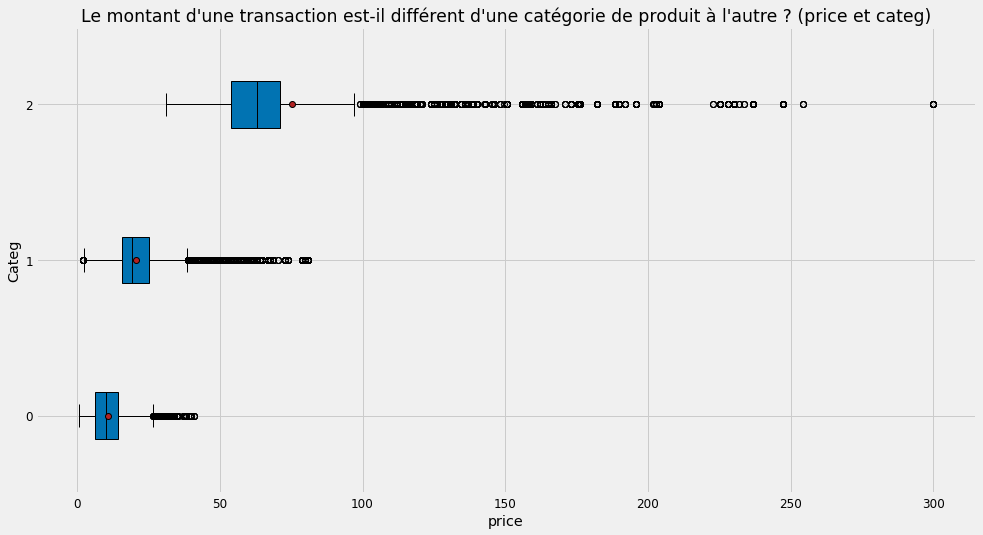

In [39]:
X1 = "categ" # qualitative
Y2 = "price" # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))
# visualisation boxplots
modalites = df_1[X1].unique()
groupes = []
for m in modalites:
    groupes.append(df_1[df_1[X1]==m][Y2])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,8))
plt.title("Le montant d'une transaction est-il différent d'une catégorie de produit à l'autre ? (price et categ)");
plt.xlabel('price')
plt.ylabel('Categ')
plt.boxplot(groupes, labels=modalites, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [40]:
# calcule
X1 = "categ" # qualitative
Y2 = "price" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(df_1[X1],df_1[Y2])

0.6442850377799269

 <div class ="alert alert-block alert-success"> 

On a obtenu $ η^2_{Y/X}=0,64 $, cela signifie que <b>les moyennes sont diffèrentes</b>, donc à priori il existe une <b>correlation entre la variable categ et la variable price</b>. 
    
</div>

# Mission 3 : questions du manager

### Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ? 

<div class ="alert alert-block alert-info"> 
<b>Test basé sur une analyse factorielle des corespondances (AFC) qui se traduit par l'observation des modalités des variables sex et categ avec avec le chi-deux $\chi ^2$ et le coefficient du $V$ de Cramers </b>


$ \ $  
    
<b>Hypothèse nulle H0:</b>  la proportion des categ de produits achetés est independante du sex.
    
$ \ $  
        
<b>Hypothèse alternative H1:</b>  la proportion des categ de produits achetés est associé au sex.
    
$ \ $  
       
<b>Seuil de signification</b> :$\alpha =0,05 $
    
$ \ $
        
$ si P_{value}  \leq \alpha$, on rejette H1 en faveur de H0

$ \ $    

$ si P_{value} > \alpha$, on ne va pas rejeter H1
H0 sera rejetée

$ \ $  
    
Pour cela, on va construir une matrice de contingence 
    
$ \ $
    

On va mesurer cette liaison avec le chi-deux $\chi ^2$:  


$ \displaystyle \chi^2=\sum_{i,j}\frac{(n_{ij}-{\frac {n_i.n_.j}{n}})^2} {\frac {n_i.n_.j}{n}} $

$ \ $    

$i$ Modalité 1er variable
   
$j$ Modalité 2eme variable

$n$ C'est le total du nombre d'observation
    
        
$ \ $
     
Avec le coefficient du $V$ de Cramer's on va estimer la force du lien:

$ \displaystyle V=\sqrt{\frac{\chi^2}{min(k-1,r-1)}}=\sqrt{\frac{\chi^2/n}{min(k-1,r-1)}}$

$ \ $   
    
$\chi ^2$ Derivée du test chi carré de Pearson

$n$ C'est le total du nombre d'observation

$k$ Le nombre de colonnes

$r$ Le nombre de lignes 
    
$ \ $    
    
</div>

In [41]:
# interprétation de la valeur du coefficient de Cramer V
Interpret_Vcramers = pd.DataFrame( {"Coefficient de V en %": pd.Categorical(["[0 ; 5%]", "[5 ; 10%]", "[10 ; 20%]", "[20 ; 40%]","[40 ; 100%]"]),"intensité du lien": pd.Categorical(["très faible", "faible", "moyenne", "forte","très forte"]),})
Interpret_Vcramers 

,Coefficient de V en %,intensité du lien
0,[0 ; 5%],très faible
1,[5 ; 10%],faible
2,[10 ; 20%],moyenne
3,[20 ; 40%],forte
4,[40 ; 100%],très forte


###### Interprétation P-valeur

$ si P_{value}  \leq \alpha$, on rejette H1 en faveur de H0

$ si P_{value} > \alpha$, on ne va pas pouvoir rejeter H1
H0 sera rejetée

In [42]:
# création echantillon
df_test0=df_1.loc[:,['sex','categ']]

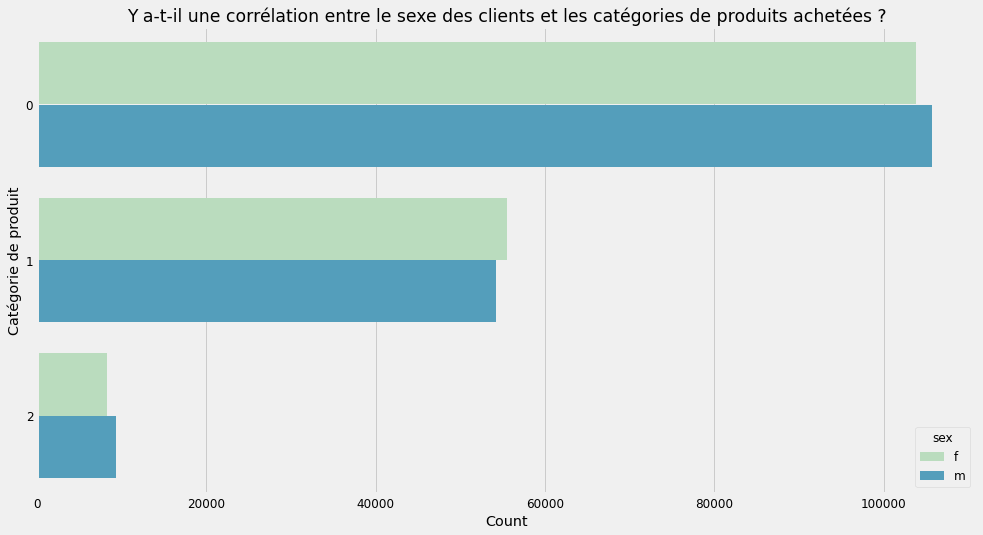

In [43]:
# visualisation des ventes en fonction du sex et de la categ de produit acheté
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,8))
sns.countplot(y ='categ', hue = "sex", data = df_test0, palette="GnBu") 
plt.xlabel('Count')
plt.ylabel('Catégorie de produit')
plt.title("Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetées ?");
plt.show()

In [44]:
#Fonction Khi2 et V Cramers
from scipy.stats import chi2_contingency

def cramers_V(var1,var2):
    """Evalue par une normalisation du chi-deux entre 0 et 100% 
    la force de la corrélation entre 2 variables catégorielles"""
    crosstab=np.array(pd.crosstab(var1,var2, rownames=None,colnames=None)) # table de contingence
    stat=chi2_contingency(crosstab)# [H0] # Valeur de la statistique du test
    obs=np.sum(crosstab) # nombre d'observation (effectifs)
    mini=min(crosstab.shape)-1 # min(p,q)-1 plus petit du nombre de colonnes ou de lignes moins 1 degré liberté
    return ((np.sqrt(stat[0]/(obs*mini))),stat[1]*100)# cramer : racine carré du Khi2 divisé par (effectifs total multiplier par mini)

In [45]:
# Encodage par transformer des modalités
from sklearn import preprocessing
label=preprocessing.LabelEncoder()
data_encoded=pd.DataFrame()

for i in df_test0.columns: 
    data_encoded[i]=label.fit_transform(df_test0[i])

In [46]:
# L'association avec sex indique dans quelle mesure les données sont conformes à l'hypothèse de test 
rows=[]
for var in data_encoded:
    col=[]
    cramers=cramers_V(data_encoded[var], data_encoded.sex)[0]
    col.append(round(cramers*100,3))
    rows.append(col)

c_r1=np.array(rows)
df_2=pd.DataFrame(c_r1, columns=['association avec sex (%)'],index=data_encoded.columns)

# La p valeur indique dans quelle mesure les données sont conformes à l'hypothèse de test et à ses hypothèses
rows_2=[]

for var in data_encoded:
    col2=[]
    P=cramers_V(data_encoded[var], data_encoded.sex)[1]
    col2.append(P)
    rows_2.append(col2)

c_r2=np.array(rows_2)
df_3=pd.DataFrame(c_r2, columns=['P-value (%)'],index=data_encoded.columns)

df_V=pd.concat([df_2,df_3],axis=1)
df_V.sort_values(by='association avec sex (%)')

,association avec sex (%),P-value (%)
categ,1.558,1.785775e-16
sex,99.999,0.000000e+00


<div class ="alert alert-block alert-success"> 
Il apparait un <b>très faible lien</b> entre  la variable sex et categ, il est <b> hautement significatif</b> du point de vu de la P valeur, aussi, <b>on va rejeter l'hypothèse H0</b>. 
    
$ \ $  
    
En somme, il y a une <b>très faible corrélation</b> entre le sexe des clients et les catégories de produits achetés.
</div>

### Y a-t-il une corrélation entre l'âge des clients et la montant total des achats ?

<div class ="alert alert-block alert-info"> 
<b>On va calculer la covariance empirique et le coefficient de corrélation pour estimer la correlation entre la variable âge et la variable price.</b> 

$ \ $

<b>Hypothèses nulle H0:</b> Pas de corrélation entre la variable age et la variable price : $ ρ = 0 $

$ \ $   
    
<b>Hypothèses alternative H1:</b>  Corrélation entre la variable age et la variable price  : $ ρ ≠ 0  $     
    
    
    
$ \ $ 
    
<b>La covariance</b> empirique :

$ \displaystyle\ s{_X,_Y}=\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^2 (y_i-\bar{y})^2$

$ \ $

On ramene la covariance empirique à une valeur qui soit comprise entre -1 et 1 en divisant par le produit des ecarts-types afin de calculer le coefficient de corrélation de Pearson.:

$ \ $
          
$ \displaystyle\ r{_X},{_Y}=\frac{^SX,Y}{^SX^SY} $ 
 
$ \ $  
    

    
</div>

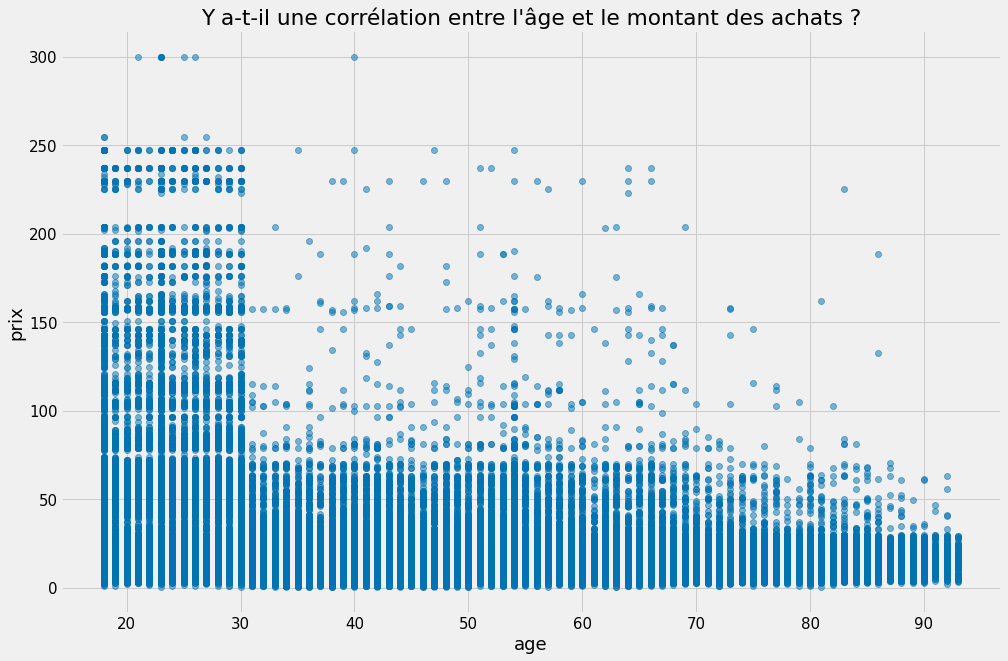

In [47]:
# visualisation de la corrélation entre l'age et le montant des achats
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
ventesAge = df_1
plt.plot(ventesAge["age"],ventesAge["price"],'o',alpha=0.5)
plt.xlabel("age")
plt.ylabel("prix")
plt.title("Y a-t-il une corrélation entre l'âge et le montant des achats ?");
plt.show()

In [48]:
# coeficient de correlation (r ou de Pearson)linéaire
print(st.pearsonr(ventesAge["age"],ventesAge["price"])[0])

-0.21150490034925462


 <div class ="alert alert-block alert-success"> 
   
Le coefficient corrélation est faible $ρ = -0,211$ car sa forme n'est pas linéaire et <b> on rejette H0 </b> .
    
$ \ $  
     
En somme, il y a une <b> corrélation</b> entre l'âge des clients et la montant total des achats.     
</div>

### Y a-t-il une corrélation entre l'âge des clients et la fréquence des achats ?

<div class ="alert alert-block alert-info"> 

<b>Comme précèdemment, ce test est basé sur une analyse factorielle des corespondances (AFC) qui se traduit par l'observation des modalités des variables age (discrétisée) et mois avec le chi-deux $\chi ^2$ et le coefficient du $V$ de Cramers </b>.

$ \ $
    
<b>Hypothèse nulle H0:</b> la fréquence d'achat par mois est independante de l'age des clients.
    
$ \ $
    
<b>Hypothèse alternative H1:</b> la fréquence d'achat par mois est associé à l'age des clients..

$ \ $    
   
seuil de signification $\alpha =0,05 $
    

         
    
</div>

In [49]:
# Création d'une variable mois
df_1['mois'] = df_1.date.dt.month

In [50]:
# Création du dataframe 
df_test=df_1.loc[:,['age','mois']]
#Discrétisation de la variable age
df_test.age=pd.cut(df_test.age,bins=10)

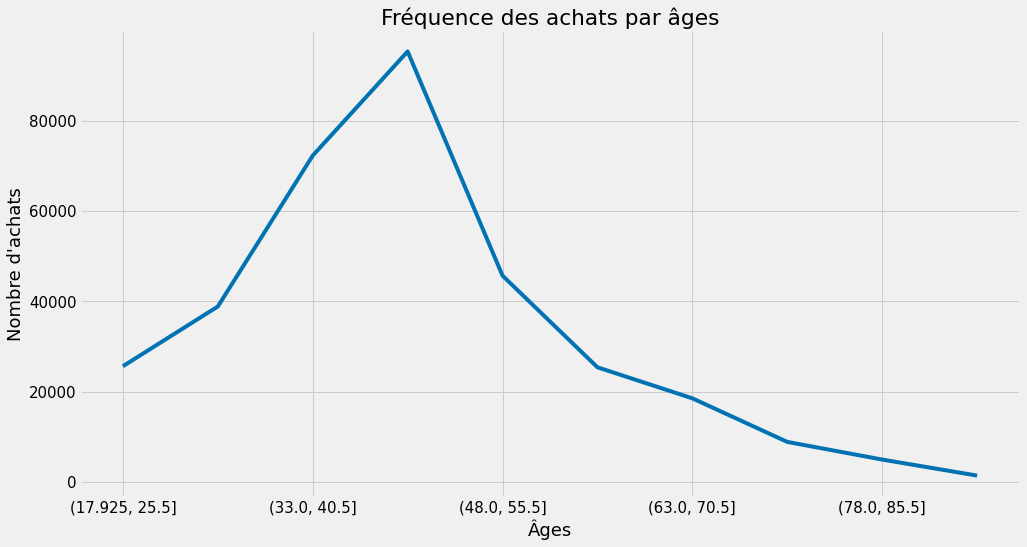

In [51]:
# visualisation de la courbe de la fréquence d'achat par ages
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,8))
plt.grid()
df_test.age.value_counts().sort_index().plot()
plt.ylabel("Nombre d'achats")
plt.xlabel("Âges")
plt.title("Fréquence des achats par âges");

In [52]:
# Encodage par transformer des modalités
from sklearn import preprocessing
label=preprocessing.LabelEncoder()
data_encoded=pd.DataFrame()

for i in df_test.columns: # fonction pour traiter les collonnes car Labelecoder ne peut traiter qu'une colonne à la fois
    data_encoded[i]=label.fit_transform(df_test[i])

In [53]:
# L'association avec age indique dans quelle mesure les données sont conformes à l'hypothèse de test 
rows=[]
for var in data_encoded:
    col=[]
    cramers=cramers_V(data_encoded[var], data_encoded.age)[0]
    col.append(round(cramers*100,3))
    rows.append(col)

c_r1=np.array(rows)
df_2=pd.DataFrame(c_r1, columns=['association avec age (%)'],index=data_encoded.columns)

# La p valeur indique dans quelle mesure les données sont conformes à l'hypothèse de test et à ses hypothèses
rows_2=[]

for var in data_encoded:
    col2=[]
    P=cramers_V(data_encoded[var], data_encoded.age)[1]
    col2.append(P)
    rows_2.append(col2)

c_r2=np.array(rows_2)
df_3=pd.DataFrame(c_r2, columns=['P-value (%)'],index=data_encoded.columns)

df_V=pd.concat([df_2,df_3],axis=1)
df_V.sort_values(by='association avec age (%)')

,association avec age (%),P-value (%)
mois,2.506,0.0
age,100.000,0.0


<div class ="alert alert-block alert-success"> 
    
Il apparait un <b>très faible lien</b> entre  la variable âge et mois, il est <b> hautement significatif du point de vu de la P valeur</b>, aussi, <b>on va rejeter l'hypothèse H0</b>.

$ \ $

En somme, il y à une <b>corrélation</b> entre l'âge des clients et la fréquence des achats même si celles_ci est très faible.
</div>

### Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombe d'article) ?

<div class ="alert alert-block alert-info"> 
    
<b>Comme précèdemment ce test sera basé sur une analyse factorielle des corespondances (AFC) qui se traduit par l'observation des modalités des variables âge et panier moyen avec le chi-deux $\chi ^2$ et le coefficient du $V$ de Cramers </b>.

$ \ $
    
<b>Hypothèse nulle H0:</b> la taille du panier moyen (en nombre d'article) est independant de l'age des clients.

    
$ \ $
    
<b>Hypothèse alternative H1:</b> la taille du panier moyen (en nombre d'article) est associé à l'age des clients. 
    
$ \ $

<b>Seuil de signification</b> : $\alpha =0,05 $    
    
</div>

In [54]:
# création dataframe de test
df_test4=df_1.loc[:,['age','price','mois', 'id_prod']]
# nombre de produits par classe d'age
df_test4=df_test4.groupby('age').id_prod.count().reset_index()
#Discrétisation de la variable age
df_test4.age=pd.cut(df_test4.age,bins=10)
df_test4 

,age,id_prod
0,"(17.925, 25.5]",7348
1,"(17.925, 25.5]",2182
2,"(17.925, 25.5]",2224
3,"(17.925, 25.5]",2032
4,"(17.925, 25.5]",2175
...,...,...
71,"(85.5, 93.0]",164
72,"(85.5, 93.0]",159
73,"(85.5, 93.0]",84
74,"(85.5, 93.0]",115


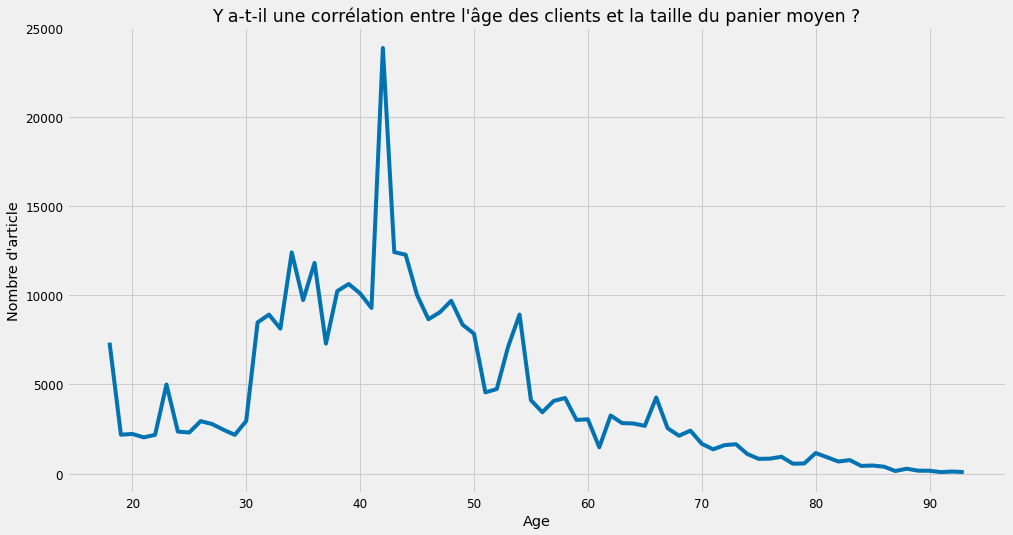

In [63]:
# visualisation de l'age des clients et la taille du panier moyen
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,8))
plt.grid()
df_1.age.value_counts().sort_index().plot()
plt.ylabel("Nombre d'article")
plt.xlabel("Age")
plt.title("Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen ?");

In [64]:
# Encodage par transformer des modalités
from sklearn import preprocessing
label=preprocessing.LabelEncoder()
data_encoded=pd.DataFrame()

for i in df_test4.columns: 
    data_encoded[i]=label.fit_transform(df_test4[i])

In [65]:
# L'association avec price indique dans quelle mesure les données sont conformes à l'hypothèse de test 
rows=[]
for var in data_encoded:
    col=[]
    cramers=cramers_V(data_encoded[var], data_encoded.age)[0]
    col.append(round(cramers*100,3))
    rows.append(col)

c_r1=np.array(rows)
df_2=pd.DataFrame(c_r1, columns=['association avec age (%)'],index=data_encoded.columns)

# La p valeur indique dans quelle mesure les données sont conformes à l'hypothèse de test et à ses hypothèses
rows_2=[]

for var in data_encoded:
    col2=[]
    P=cramers_V(data_encoded[var], data_encoded.age)[1]
    col2.append(P)
    rows_2.append(col2)

c_r2=np.array(rows_2)
df_3=pd.DataFrame(c_r2, columns=['P-value (%)'],index=data_encoded.columns)

df_V=pd.concat([df_2,df_3],axis=1)
df_V.sort_values(by='association avec age (%)')

,association avec age (%),P-value (%)
age,100.0,3.229796e-94
id_prod,100.0,3.966629e+01


<div class ="alert alert-block alert-success"> 
Il apparait un <b>très fort lien</b> entre  l'age des clients et leurs paniers moyens en nombre d'artices  et il est <b>significatif du point de vu de la P valeur</b> , aussi, on <b> rejette l'hypothèse H0</b>.

En somme, il n'y a une <b> très forte corrélation</b>  entre l'âge des clients et la taille du panier moyen (en nombe d'article).
</div>

###  Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés

<div class ="alert alert-block alert-info"> 
   
<b>Comme précèdemment, ce test sera basé sur une analyse factorielle des corespondances (AFC) qui se traduit par l'observation des modalités des variables âge et categ avec le chi-deux $ \chi ^2$ et le coefficient du $V$ de Cramers .  </b>

$ \ $
    
<b>Hypothèse nulle H0:</b> les catégorie de produits achetées sont independantes de l'age des clients.
    
$ \ $
    
<b>Hypothèse alternative H1:</b> les catégorie de produits acheteés sont associées à l'âge des clients.
    
</div>

In [66]:
# Creation de l'échantillon
df_test5=df_1.loc[:,['age','categ']]
# Discrétisation de la variable age
df_test5.age=pd.cut(df_test5.age,bins=10)

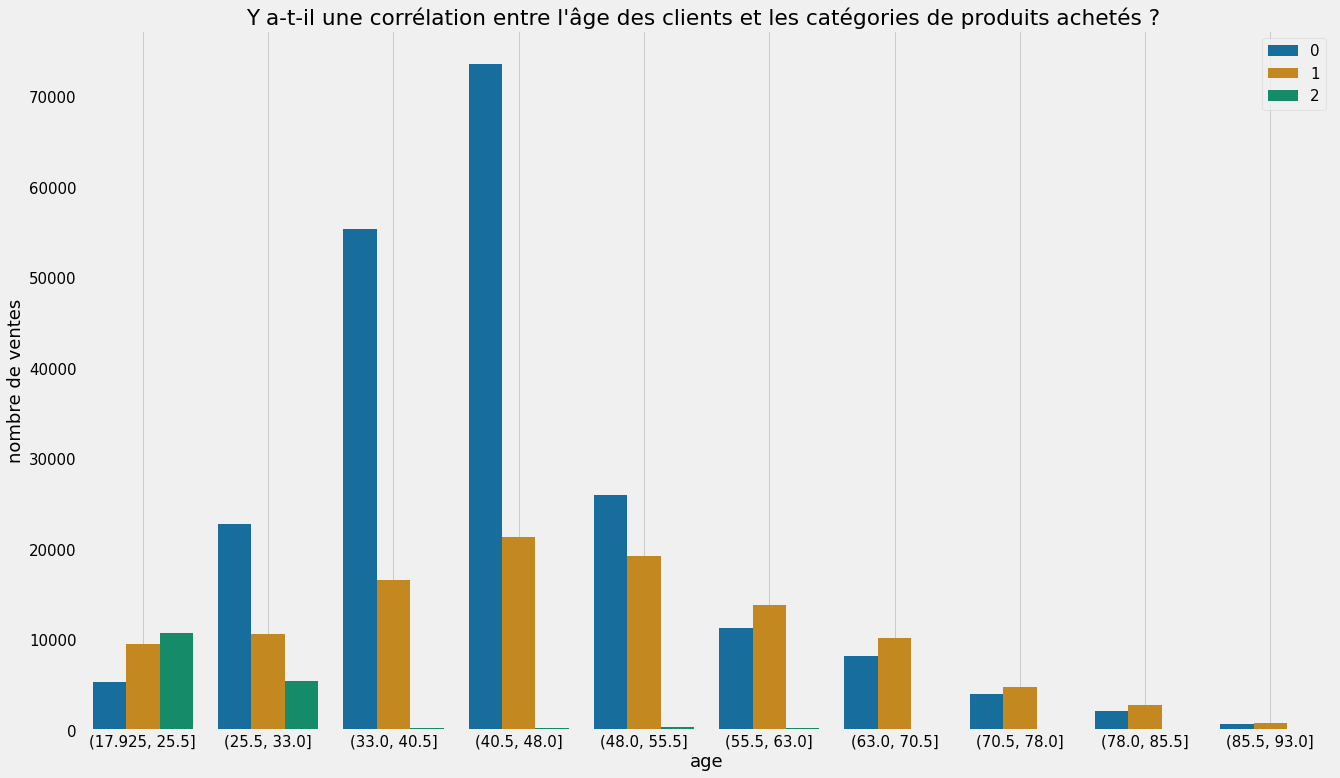

In [67]:
# visualisation des catégories de produit achetées  par age
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,12))
sns.countplot('age', hue='categ', data= df_test5,palette="colorblind")
plt.ylabel("nombre de ventes")
plt.grid()
plt.legend()
plt.title("Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ? ");


In [68]:
# Encodage par transformer des modalités
from sklearn import preprocessing
label=preprocessing.LabelEncoder()
data_encoded=pd.DataFrame()

for i in df_test5.columns: 
    data_encoded[i]=label.fit_transform(df_test5[i])

In [69]:
# L'association avec price indique dans quelle mesure les données sont conformes à l'hypothèse de test 
rows=[]
for var in data_encoded:
    col=[]
    cramers=cramers_V(data_encoded[var], data_encoded.age)[0]
    col.append(round(cramers*100,3))
    rows.append(col)

c_r1=np.array(rows)
df_2=pd.DataFrame(c_r1, columns=['association avec age (%)'],index=data_encoded.columns)

# La p valeur indique dans quelle mesure les données sont conformes à l'hypothèse de test et à ses hypothèses
rows_2=[]

for var in data_encoded:
    col2=[]
    P=cramers_V(data_encoded[var], data_encoded.age)[1]
    col2.append(P)
    rows_2.append(col2)

c_r2=np.array(rows_2)
df_3=pd.DataFrame(c_r2, columns=['P-value (%)'],index=data_encoded.columns)

df_V=pd.concat([df_2,df_3],axis=1)
df_V.sort_values(by='association avec age (%)')

,association avec age (%),P-value (%)
categ,41.479,0.0
age,100.000,0.0


<div class ="alert alert-block alert-success"> 
Il apparait un <b>très fort lien</b> entre l'age des clients et les categories de produits achetées. Il est <b>hautement significatif</b> du point de vu de la P valeur, aussi, on va <b>rejeter l'hypothèse H0</b>.
    
En somme, il y une <b>corrélation</b> entre l'âge des clients et les catégories de produits achetés. 
</div>

#### références:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

https://en.wikipedia.org/wiki/Welch%27s_t-test

https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4742171-representez-la-distribution-empirique-dune-variable

http://wikistat.fr/pdf/st-m-modmixt3-anova.pdf

http://wikistat.fr/pdf/st-m-inf-khi2.pdf